# **Using Contrastive Learning to pretrain a CNN model for hand-writen image classification based on MNIST dataaset.**

### Prepared By: Muhammad Luqman
### E-mail: luqmanbutt@outlook.com
### Contact: 13227703732

## Step:1 Import and Install Dependencies

In [1]:
# install tf-addons
!pip install tensorflow-addons
!pip install umap-learn


# import libraries
import tensorflow as tf
import tensorflow_addons as tfa
import numpy as np
from tensorflow import keras
from tensorflow.keras import layers
import umap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


/usr/local/lib/python3.9/dist-packages/tensorflow_addons/utils/tfa_eol_msg.py:23: UserWarning: 

TensorFlow Addons (TFA) has ended development and introduction of new features.
TFA has entered a minimal maintenance and release mode until a planned end of life in May 2024.
Please modify downstream libraries to take dependencies from other repositories in our TensorFlow community (e.g. Keras, Keras-CV, and Keras-NLP). 

For more information see: https://github.com/tensorflow/addons/issues/2807 

  warnings.warn(


## Step:2 Import Dataset

In [2]:
# Load the train and test data splits
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()

# check shape of data
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (60000, 28, 28) - y_train shape: (60000,)
x_test shape: (10000, 28, 28) - y_test shape: (10000,)


## Step:3 Data Pre-processing
- We are going to use pre-trained CNN model
- Minimum input_size required is 32x32, but in ourdataset is 28x28
- So, we have to reshape data

In [3]:
# reshape training set
x_train = np.expand_dims(x_train, axis=-1) # reshape
x_train = tf.image.resize(x_train, [32,32]) 

# reshape test set
x_test = np.expand_dims(x_test, axis=-1) # reshape
x_test = tf.image.resize(x_test, [32,32]) # reshape

# Display shapes of train and test datasets
print(f"x_train shape: {x_train.shape} - y_train shape: {y_train.shape}")
print(f"x_test shape: {x_test.shape} - y_test shape: {y_test.shape}")

x_train shape: (60000, 32, 32, 1) - y_train shape: (60000,)
x_test shape: (10000, 32, 32, 1) - y_test shape: (10000,)


In [4]:
# Normalize the data
x_train = x_train / 255.0
x_test = x_test /255.0

## Step:4 Data Augmentation

In [5]:
data_augmentation = keras.Sequential(
    [
        layers.Normalization(),
        layers.RandomFlip("horizontal"),
        layers.RandomRotation(0.02),
        layers.RandomWidth(0.2),
        layers.RandomHeight(0.2),
    ]
)

# Setting the state of the normalization layer.
data_augmentation.layers[0].adapt(x_train)

## Step:5 Contrastive Learning Model Development
### Built Encoder
- The encoder model takes the input image and turns it into a feature vector.

In [6]:
# Model / data parameters
num_classes = 10
input_shape = (32, 32, 1)

In [7]:
def create_encoder():
    resnet = keras.applications.ResNet50V2(
        include_top=False, weights=None, input_shape=input_shape, pooling="avg"
    )

    inputs = keras.Input(shape=input_shape)
    augmented = data_augmentation(inputs)
    outputs = resnet(augmented)
    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist-encoder")
    return model


encoder = create_encoder()
encoder.summary()

learning_rate = 0.001
batch_size = 265
hidden_units = 512
projection_units = 128
num_epochs = 10
dropout_rate = 0.5
temperature = 0.05

Model: "mnist-encoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 sequential (Sequential)     (None, None, None, 1)     3         
                                                                 
 resnet50v2 (Functional)     (None, 2048)              23558528  
                                                                 
Total params: 23,558,531
Trainable params: 23,513,088
Non-trainable params: 45,443
_________________________________________________________________


### Build Classifier
- The classification model adds a fully-connected layer on top of the encoder, plus a softmax layer with the target classes.

In [8]:
def create_classifier(encoder, trainable=True):

    for layer in encoder.layers:
        layer.trainable = trainable

    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    features = layers.Dropout(dropout_rate)(features)
    features = layers.Dense(hidden_units, activation="relu")(features)
    features = layers.Dropout(dropout_rate)(features)
    outputs = layers.Dense(num_classes, activation="softmax")(features)

    model = keras.Model(inputs=inputs, outputs=outputs, name="mnist-classifier")
    model.compile(
        optimizer=keras.optimizers.Adam(learning_rate),
        loss=keras.losses.SparseCategoricalCrossentropy(),
        metrics=['Accuracy'])
    return model

### Supervised Contrastive Learning Loss Function
- The encoder is pretrained to optimize the supervised contrastive loss

In [9]:
# contrastive loss function
class SupervisedContrastiveLoss(keras.losses.Loss):
    def __init__(self, temperature=1, name=None):
        super().__init__(name=name)
        self.temperature = temperature

    def __call__(self, labels, feature_vectors, sample_weight=None):
        # Normalize feature vectors
        feature_vectors_normalized = tf.math.l2_normalize(feature_vectors, axis=1)
        # Compute logits
        logits = tf.divide(
            tf.matmul(
                feature_vectors_normalized, tf.transpose(feature_vectors_normalized)
            ),
            self.temperature,
        )
        return tfa.losses.npairs_loss(tf.squeeze(labels), logits)


def add_projection_head(encoder):
    inputs = keras.Input(shape=input_shape)
    features = encoder(inputs)
    outputs = layers.Dense(projection_units, activation="relu")(features)
    model = keras.Model(
        inputs=inputs, outputs=outputs, name="mnist-encoder_with_projection-head"
    )
    return model

### Encoder Pre-training

In [10]:
# pre-train the encoder
encoder = create_encoder()

encoder_with_projection_head = add_projection_head(encoder)
encoder_with_projection_head.compile(
    optimizer=keras.optimizers.Adam(learning_rate),
    loss=SupervisedContrastiveLoss(temperature),
)

encoder_with_projection_head.summary()

history = encoder_with_projection_head.fit(
    x=x_train, y=y_train, batch_size=batch_size, epochs=num_epochs
)

Model: "mnist-encoder_with_projection-head"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_5 (InputLayer)        [(None, 32, 32, 1)]       0         
                                                                 
 mnist-encoder (Functional)  (None, 2048)              23558531  
                                                                 
 dense (Dense)               (None, 128)               262272    
                                                                 
Total params: 23,820,803
Trainable params: 23,775,360
Non-trainable params: 45,443
_________________________________________________________________
Epoch 1/10
227/227 [==============================] - 95s 242ms/step - loss: 4.1934
Epoch 2/10
227/227 [==============================] - 31s 138ms/step - loss: 3.6057
Epoch 3/10
227/227 [==============================] - 31s 135ms/step - loss: 3.5185
Epoch 4/10
227/227 [=======

### Classifier Training with the Frozen Encoder

In [11]:
classifier = create_classifier(encoder, trainable=False)

history = classifier.fit(x=x_train, y=y_train,validation_data=(x_test,y_test), batch_size=batch_size, epochs=10)

Epoch 1/10
227/227 [==============================] - 16s 49ms/step - loss: 0.1153 - Accuracy: 0.9757 - val_loss: 0.0455 - val_Accuracy: 0.9872
Epoch 2/10
227/227 [==============================] - 8s 35ms/step - loss: 0.0799 - Accuracy: 0.9806 - val_loss: 0.0417 - val_Accuracy: 0.9875
Epoch 3/10
227/227 [==============================] - 9s 38ms/step - loss: 0.0747 - Accuracy: 0.9812 - val_loss: 0.0458 - val_Accuracy: 0.9871
Epoch 4/10
227/227 [==============================] - 8s 37ms/step - loss: 0.0752 - Accuracy: 0.9806 - val_loss: 0.0442 - val_Accuracy: 0.9869
Epoch 5/10
227/227 [==============================] - 9s 38ms/step - loss: 0.0722 - Accuracy: 0.9809 - val_loss: 0.0419 - val_Accuracy: 0.9887
Epoch 6/10
227/227 [==============================] - 8s 36ms/step - loss: 0.0707 - Accuracy: 0.9822 - val_loss: 0.0433 - val_Accuracy: 0.9877
Epoch 7/10
227/227 [==============================] - 8s 36ms/step - loss: 0.0678 - Accuracy: 0.9827 - val_loss: 0.0432 - val_Accuracy: 0.987

### Accuracy Plot

Text(0.5, 1.0, 'Training Accuracy Graph')

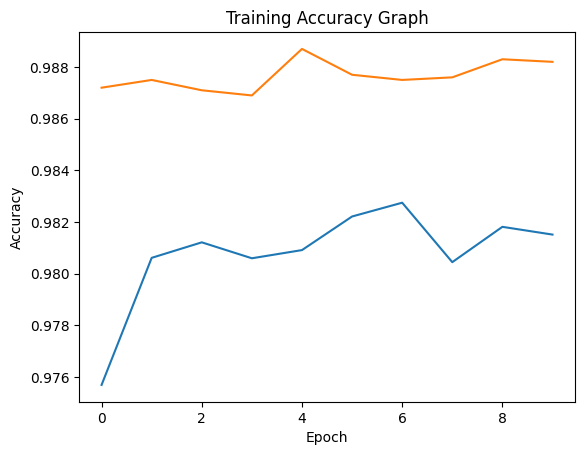

In [14]:
losst=history.history['Accuracy']
lossv=history.history['val_Accuracy']
import matplotlib.pyplot as plt
plt.plot(losst)
plt.plot(lossv)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title("Training Accuracy Graph")

### Loss Plot

Text(0.5, 1.0, 'Training Loss Graph')

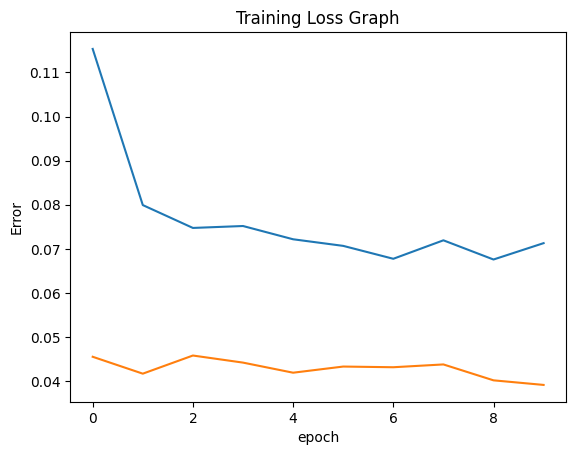

In [15]:
losst=history.history['loss']
lossv=history.history['val_loss']
import matplotlib.pyplot as plt
plt.plot(losst)
plt.plot(lossv)
plt.xlabel('epoch')
plt.ylabel('Error')
plt.title("Training Loss Graph")

### Model Evaluation

In [16]:
accuracy = classifier.evaluate(x_test, y_test)[1]
print(f"Test accuracy: {round(accuracy * 100, 2)}%")

313/313 [==============================] - 4s 12ms/step - loss: 0.0391 - Accuracy: 0.9882
Test accuracy: 98.82%


## Step:6 t-SNE Visualization

In [17]:
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

# Extract the embeddings for the training data
train_embeddings = classifier.predict(x_train)

# Extract the embeddings for the test data
test_embeddings = classifier.predict(x_test)

tsne = TSNE(n_components=2, random_state=42)
train_embeddings_tsne = tsne.fit_transform(train_embeddings)
test_embeddings_tsne = tsne.fit_transform(test_embeddings)

313/313 [==============================] - 4s 9ms/step


### Training Embedding

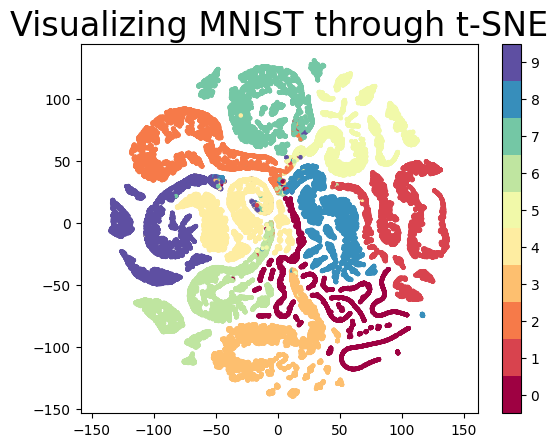

In [18]:
#visualising t-SNE
plt.scatter(train_embeddings_tsne[:, 0], train_embeddings_tsne[:, 1], s= 5, c=y_train, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualizing MNIST through t-SNE', fontsize=24);

### Test Embedding

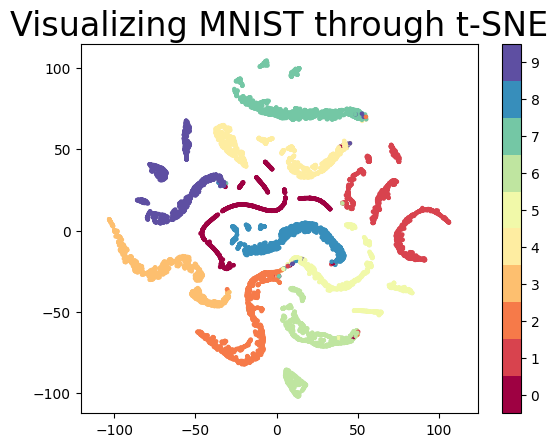

In [19]:
#visualising t-SNE
plt.scatter(test_embeddings_tsne[:, 0], test_embeddings_tsne[:, 1], s= 5, c=y_test, cmap='Spectral')
plt.gca().set_aspect('equal', 'datalim')
plt.colorbar(boundaries=np.arange(11)-0.5).set_ticks(np.arange(10))
plt.title('Visualizing MNIST through t-SNE', fontsize=24);